In [ ]:
import pickle
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS

In [ ]:
def filterByEdge(g, corr, cutOff, keepOnlyMain):
    # Filtering edges
    corr = g.edge_properties[corr]
    sign = g.new_ep("bool", True)
    sign.a = np.array(np.abs(corr.a) > cutOff)

    tv = GraphView(g, efilt=sign)

    # Keeping largest component
    if keepOnlyMain:
        comp, hist = label_components(tv)
        main_component = tv.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
        tv.vertex_properties["main_component"] = main_component
        tv.set_vertex_filter(main_component)
    return tv

In [ ]:
# Set residuals file input name, tsv format
residuals_file = "rawData/batch/example.tsv"

In [ ]:
gene_expr_raw = pd.read_table(residuals_file)
gene_expr = gene_expr_raw.T
gene_expr

In [ ]:
ge_centered = (gene_expr - gene_expr.mean()) / np.sqrt(gene_expr.var())

# Fit a covariance matrix to the centered and scaled gene expression data
# OAS shrinkage estimator: https://www.cs.huji.ac.il/~amiw/chen_tsp_2010.pdf
# https://scikit-learn.org/stable/auto_examples/covariance/plot_lw_vs_oas.html
oa = OAS(store_precision=True, assume_centered=True)
gene_expr_OAS_corr = oa.fit(ge_centered)
s_cov = gene_expr_OAS_corr.covariance_
n_genes = s_cov.shape[1]
n_genes

In [ ]:
# Set scov diagonal to zero
np.fill_diagonal(s_cov, 0)
s_cov

# Plot histogram of s_cov   
import matplotlib.pyplot as plt
plt.hist(s_cov[s_cov != 0], bins=100)
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Histogram of Correlation Values")
plt.show()  

In [ ]:
# Set absolute covariances lower than cutOff to zero
s_cov_filter = s_cov.copy()

cutOff = 0.5
s_cov_filter[abs(s_cov_filter) < cutOff] = 0

# Remove rows and columns with all zeros
s_cov_filter = s_cov_filter[~np.all(s_cov_filter == 0, axis=1)]
s_cov_filter = s_cov_filter[:, ~np.all(s_cov_filter == 0, axis=0)]

# Set lower triangle to zero
s_cov_filter = np.triu(s_cov_filter, k=1)

# Arctanh transfor correlations to make them real-valued
s_cov_filter = 2*np.arctanh(s_cov_filter)

# Create graph using graph-tool and filtered correlations as edge weights
g = Graph(sp.sparse.lil_matrix(s_cov_filter), directed=False)

# Check graph density
density = g.num_edges() / ((n_genes * n_genes - n_genes) / 2 )
print(f"Graph density: {density:.4f}")

Graph density: 0.2133


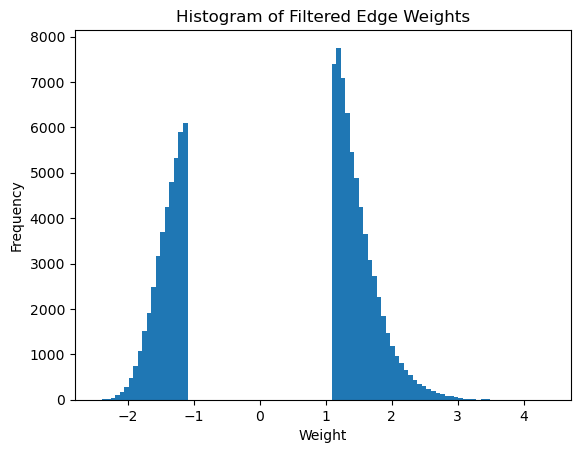

In [118]:
# Histogram of filtered edge weights
plt.hist(g.ep.weight.a, bins=100)
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.title("Histogram of Filtered Edge Weights")
plt.show()

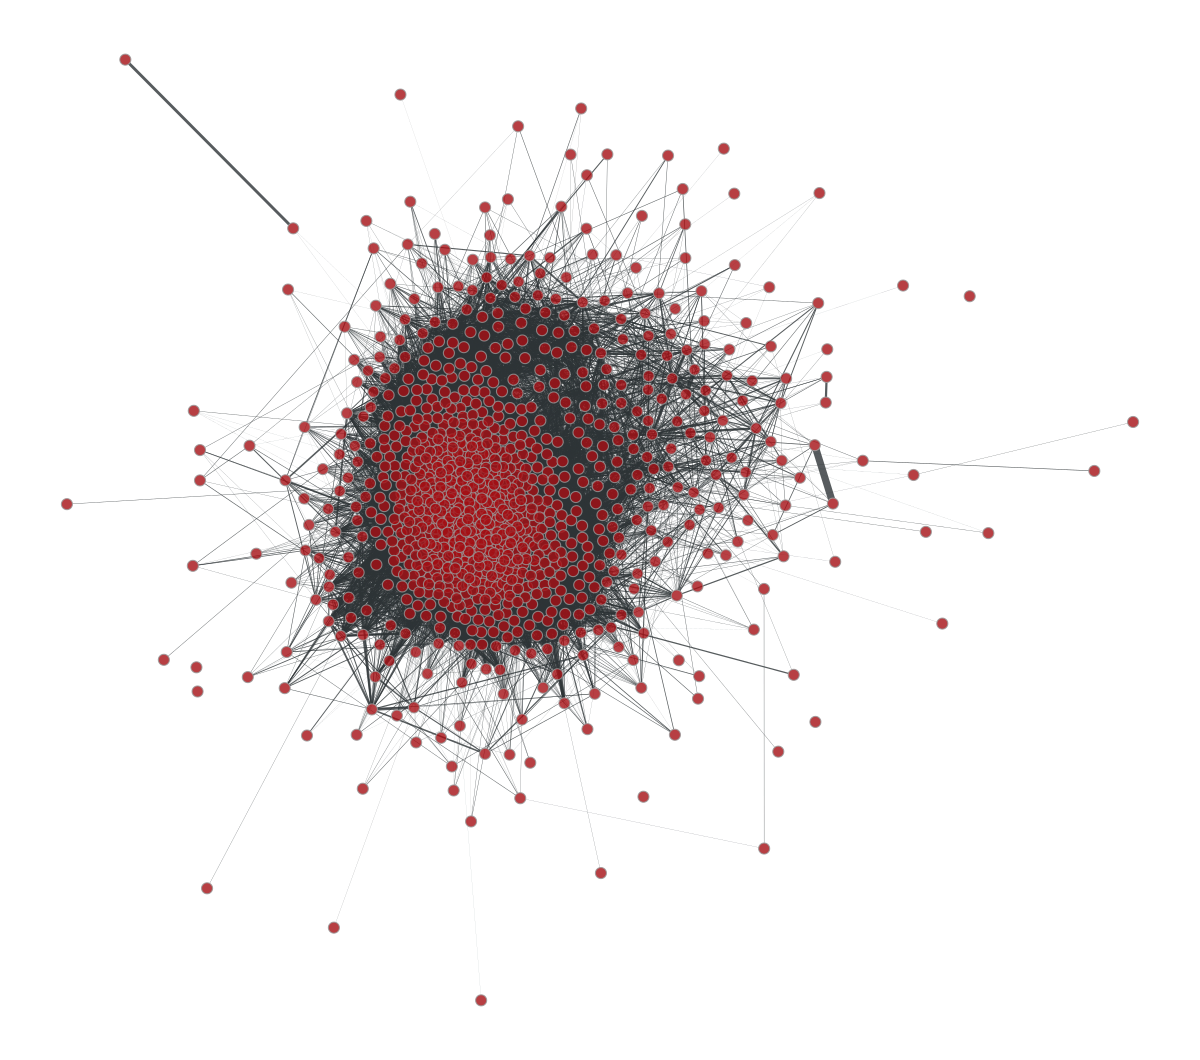

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8f76832b40, at 0x7f8f769ab320>

In [122]:
g.ep.abs_weight = g.new_edge_property("double", np.abs(g.ep.weight.fa))
graph_draw(g, edge_pen_width = prop_to_size(g.ep.abs_weight, mi=0, ma=4, power=1, log=False))


In [123]:
state = minimize_nested_blockmodel_dl(
    g, 
    state_args=dict(recs=[g.ep.weight],
                    rec_types=["real-normal"]))

In [ ]:
S1 = state.entropy()
mcmc_anneal(state, beta_range=(1, 10), niter=1000,
            mcmc_equilibrate_args=dict(force_niter=10), verbose=False)
S2 = state.entropy()
print("Improvement from annealing: " + str(S2 - S1))

In [ ]:
S1 = state.entropy()
mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10), verbose=False)
S2 = state.entropy()
print("Improvement from equilibration: " + str(S2 - S1))

In [ ]:
bstate = state.levels[0]
pos = sfdp_layout(state.get_bstack()[0], groups=bstate.get_blocks(), gamma=.02)
bstate.draw(pos=pos, vertex_color="white", edge_gradient=[],
            edge_pen_width=prop_to_size(g.ep.weight, mi=-4, ma=4, power=2, log=False))

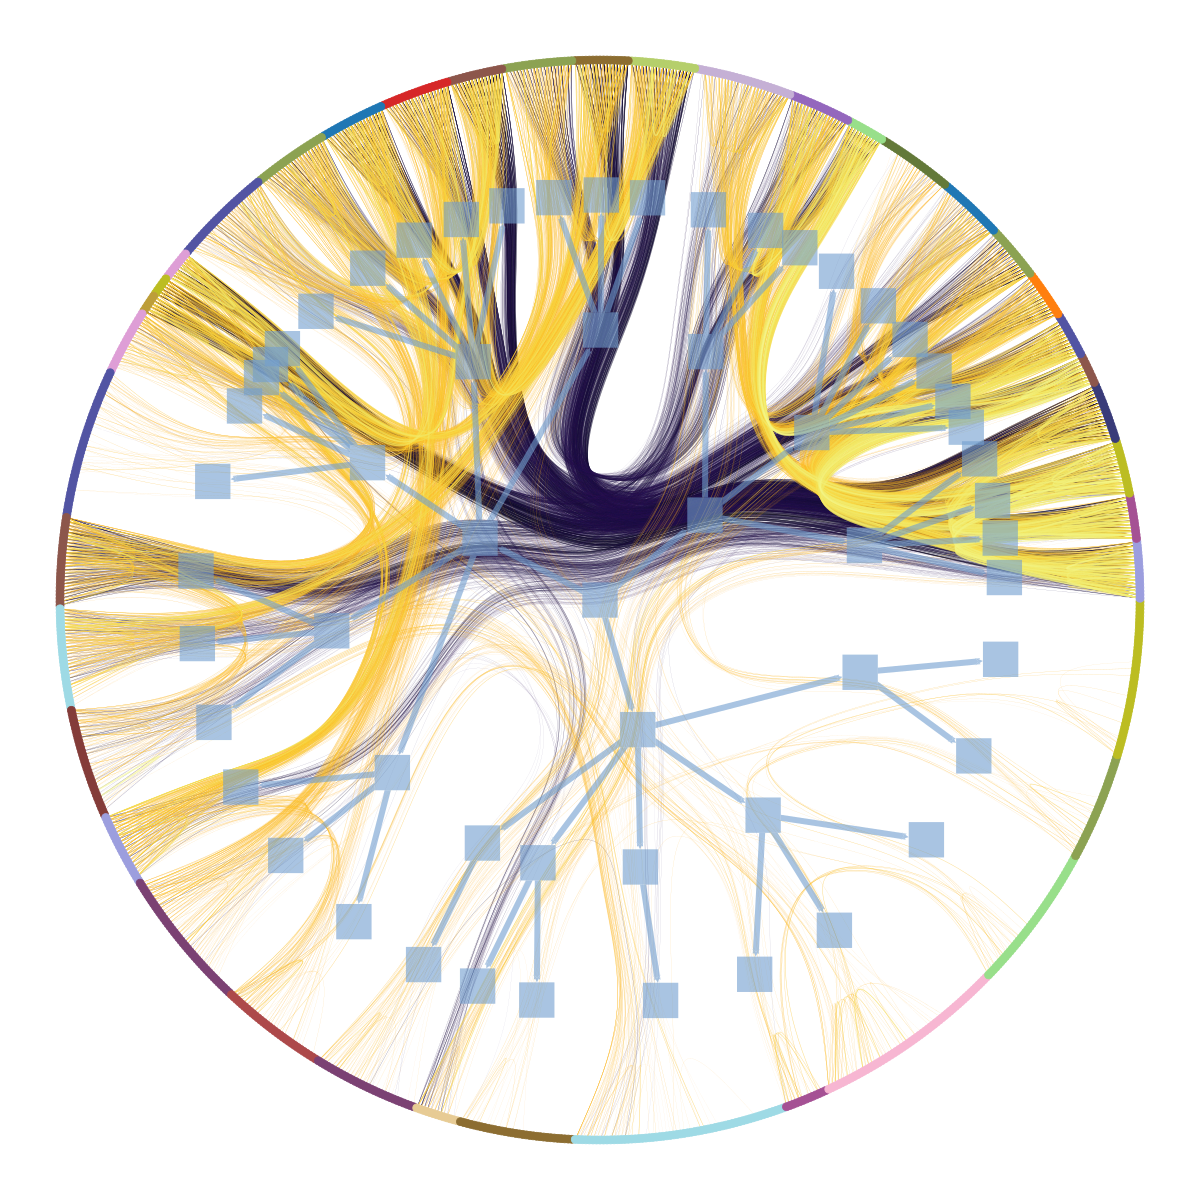

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as mpl

g.vp.level_0 = g.new_vertex_property("double", state.get_bs()[0])
g.ep.abs_weight = g.new_edge_property("double", np.abs(g.ep.weight.fa))
pos_t, twat, tpos = state.draw( eorder=g.ep.weight,
        edge_pen_width = prop_to_size(g.ep.abs_weight, mi=0, ma=4, power=1, log=False),
        edge_color=prop_to_size(g.ep.weight, mi=-4, ma=4, power=1, log=False),
        ecmap=(mpl.inferno, .6), 
        edge_gradient=[], 
        vertex_size = 4,
        hvertex_size = 25,
        hedge_pen_width = 3,
        vertex_color = g.vp.level_0,
        vertex_fill_color = g.vp.level_0,
        subsample_edges = 10000)